In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from sklearn.model_selection import train_test_split

In [103]:
train = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_training.csv")
test = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_testing.csv")

# Preprocessiong
* * * *

In [104]:
train.columns

Index(['compositeHourlyWages', 'age', 'yearsEducation', 'sex1M0F'], dtype='object')


 mu = 15.50 and sigma = 7.75



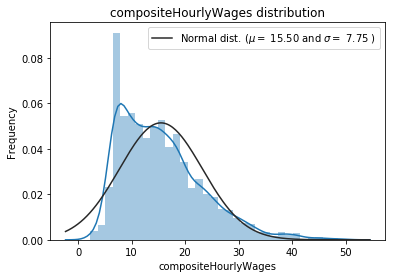

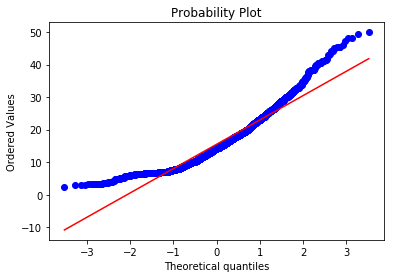


 mu = 36.88 and sigma = 12.00



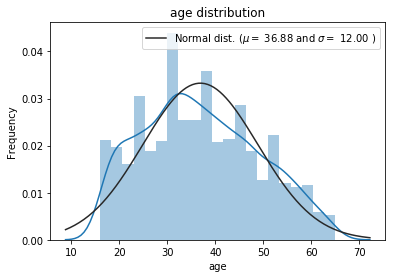

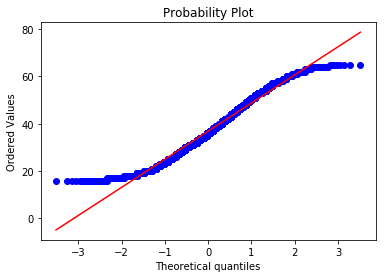


 mu = 13.18 and sigma = 3.04



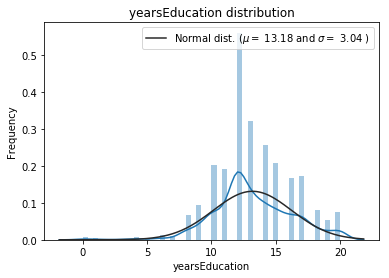

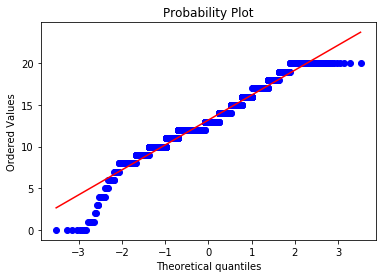


 mu = 0.49 and sigma = 0.50



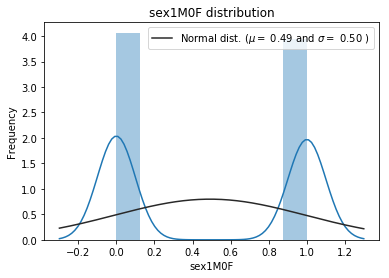

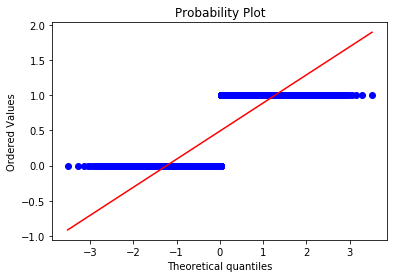

In [105]:
for column in train.columns:

    # ヒストグラムとカーネル密度推定による確率密度関数
    # fitを使えば分布のフィッティングもできる
    sns.distplot(train[column] , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train[column])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(column + ' distribution')

    #Get also the QQ-plot
    # > X軸上に観測した累積パーセント、Y軸上に期待累積パーセントを持つグラフ
    # > ヒストグラムよりなじみは薄いと思うので、わからなければ 一直線上になっていれば正規分布であるくらいに覚えておけばOK
    fig = plt.figure()
    res = stats.probplot(train[column], plot=plt)
    plt.show()


 mu = 2.70 and sigma = 0.46



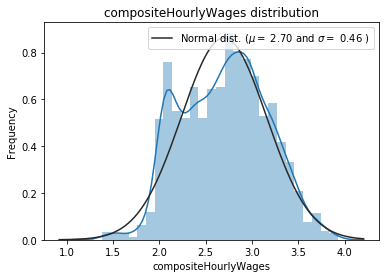

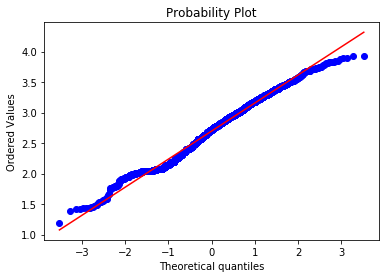

In [90]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["compositeHourlyWages"] = np.log1p(train["compositeHourlyWages"])

#Check the new distribution 
sns.distplot(train['compositeHourlyWages'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['compositeHourlyWages'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('compositeHourlyWages distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['compositeHourlyWages'], plot=plt)
plt.show()

# Preprocessing
* * *

In [91]:
train_skewed = train
test_skewed = test

In [92]:
from scipy.stats import skew

In [94]:
train.describe()

,compositeHourlyWages,age,yearsEducation,sex1M0F
count,3197.000000,3197.000000,3197.000000,3197.000000
mean,2.697233,36.884579,13.180794,0.491711
std,0.462630,11.996980,3.042127,0.500009
min,1.193922,16.000000,0.000000,0.000000
25%,2.327278,28.000000,12.000000,0.000000
50%,2.721953,36.000000,13.000000,0.000000
75%,3.027715,46.000000,15.000000,1.000000
max,3.930256,65.000000,20.000000,1.000000


In [95]:
numeric_features = train.dtypes[train.dtypes != "object"].index
numeric_features

Index(['compositeHourlyWages', 'age', 'yearsEducation', 'sex1M0F'], dtype='object')

In [96]:
skewed = train_skewed[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

train_skewed[skewed] = np.log1p(train_skewed[skewed])
test_skewed[skewed] = np.log1p(test_skewed[skewed])

In [97]:
train_skewed.describe()

,compositeHourlyWages,age,yearsEducation,sex1M0F
count,3197.000000,3197.000000,3197.000000,3197.000000
mean,2.697233,36.884579,13.180794,0.491711
std,0.462630,11.996980,3.042127,0.500009
min,1.193922,16.000000,0.000000,0.000000
25%,2.327278,28.000000,12.000000,0.000000
50%,2.721953,36.000000,13.000000,0.000000
75%,3.027715,46.000000,15.000000,1.000000
max,3.930256,65.000000,20.000000,1.000000



 mu = 2.70 and sigma = 0.46



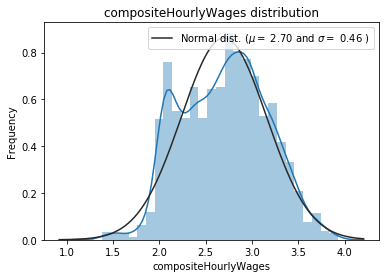

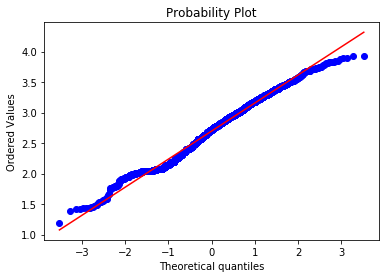

In [62]:
sns.distplot(train_skewed['compositeHourlyWages'] , fit=norm);

(mu, sigma) = norm.fit(train_skewed['compositeHourlyWages'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('compositeHourlyWages distribution')

fig = plt.figure()
res = stats.probplot(train_skewed['compositeHourlyWages'], plot=plt)
plt.show()

In [63]:
train = train_skewed
test = test_skewed

In [64]:
train_target = train.compositeHourlyWages.values

test_ID = test['ID']
test.drop("ID", axis = 1, inplace = True)

train.drop(['compositeHourlyWages'], axis=1, inplace=True)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(train,train_target,test_size=0.2,random_state=0)

# Modeling
* * * * *

## XGBoost

### 1. Validation with local train

In [66]:
# xgboostモデルの作成
#ind_params = {'objective': 'reg:linear'}

#reg = xgb.XGBRegressor(**ind_params)
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [67]:
y_train_predict = reg.predict(X_train)
y_pred = reg.predict(X_test)

In [68]:
# The error metric: RMSE
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("RMSE from local train: ", rmse(y_test, y_pred))
print("MSE from local train: ", mean_squared_error(y_test, y_pred))
print("R2 from local train: ", r2_score(y_test, y_pred))

RMSE from local train:  0.366966080046
MSE from local train:  0.134664103904
R2 from local train:  0.408541661922


### 2. Validation with GridSearch

In [69]:
from sklearn.model_selection import GridSearchCV

In [70]:
# XGBoost params
xgb_params = {
    'objective' : ['reg:gamma','reg:linear'],
    'learning_rate' : [0.05,0.1],
    'n_estimators' : [50,100,200],
    'max_depth' : [2,4,6],
    'subsample' : [0.8,0.85,0.9,0.95],
    'colsample_bytree' : [0.5,1.0],
    'min_child_weight' : [5,10,15]
}

In [71]:
#scoring_func = make_scorer(mean_squared_error)

#grid = GridSearchCV(reg,xgb_params,scoring=scoring_func,cv=5,n_jobs=-1)
grid = GridSearchCV(reg,xgb_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'objective': ['reg:gamma', 'reg:linear'], 'learning_rate': [0.05, 0.1], 'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6], 'subsample': [0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.5, 1.0], 'min_child_weight': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [72]:
# Best Params and Score
print("Best params: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)

print("MSE: ", grid.best_score_)

# best_score_ : Mean cross-validated score of the best_estimator

Best params:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 15, 'n_estimators': 200, 'objective': 'reg:gamma', 'subsample': 0.85}
Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=15, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85)
MSE:  -0.127260886854


In [73]:
# The result of combination
index = 1
for params, mean_score, scores in grid.grid_scores_:
    print("%d) %0.3f (+/-%0.03f) " % (index, mean_score, scores.std() / 2))
    print("Params: %r" % params)
    print("_"*30)
    index = index + 1

/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


1) -0.680 (+/-0.013) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.8}
______________________________
2) -0.680 (+/-0.013) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.85}
______________________________
3) -0.680 (+/-0.013) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.9}
______________________________
4) -0.680 (+/-0.013) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.95}
______________________________
5) -0.173 (+/-0.005) 
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'objecti

In [74]:
# 改めて最適パラメータで学習
gdm = xgb.XGBRegressor(**grid.best_params_) # 6.01679534923
#gdm = xgb.XGBRegressor(**xgb_params) # 6.0907929398
gdm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=2, min_child_weight=15, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85)

In [81]:
y_pred_gdm = gdm.predict(X_test)

In [83]:
y_test = np.exp(y_test)
y_pred_gdm = np.exp(y_pred_gdm)

In [85]:
# The error metric: RMSE
print("RMSE from local train: ", rmse(y_test, y_pred_gdm))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gdm))
print("R2 from local train: ", r2_score(y_test, y_pred_gdm))

RMSE from local train:  6.08023098396
MSE from local train:  36.9692088183
R2 from local train:  0.384046284389


In [86]:
predictions_gdm = gdm.predict(test)

In [78]:
predictions_gdm = np.exp(predictions_gdm)

# Submission

In [79]:
sub = pd.DataFrame()
sub['ID'] = test_ID
sub['compositeHourlyWages'] = predictions_gdm
sub.to_csv('rs_hourly_submission_27Dec17_rs_predict_hourly_wage_v04_xgb_log.csv',index=False)

* * * *

Public LB: 6.32968